# Hybrid PC on MNIST

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/thebuckleylab/jpc/blob/main/examples/hybrid_pc.ipynb)

This notebook demonstrates how to train a hybrid predictive coding network that can both generate and classify MNIST digits.

In [1]:
%%capture
!pip install torch==2.3.1
!pip install torchvision==0.18.1
!pip install matplotlib==3.0.0

In [2]:
import jpc

import jax
import jax.numpy as jnp
import equinox as eqx
import equinox.nn as nn
import optax

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

## Hyperparameters

We define some global parameters, including network architecture, learning rate, batch size etc.

In [3]:
SEED = 0

LAYER_SIZES = [10, 300, 300, 784]
ACT_FN = "relu"

LEARNING_RATE = 1e-3
BATCH_SIZE = 64
N_INFER_ITERS = 200
TEST_EVERY = 100
N_TRAIN_ITERS = 300

## Dataset

Some utils to fetch MNIST.

In [4]:
#@title data utils


def get_mnist_loaders(batch_size):
    train_data = MNIST(train=True, normalise=True)
    test_data = MNIST(train=False, normalise=True)
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    test_loader = DataLoader(
        dataset=test_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    return train_loader, test_loader


class MNIST(datasets.MNIST):
    def __init__(self, train, normalise=True, save_dir="data"):
        if normalise:
            transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=(0.1307), std=(0.3081)
                    )
                ]
            )
        else:
            transform = transforms.Compose([transforms.ToTensor()])
        super().__init__(save_dir, download=True, train=train, transform=transform)

    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        img = torch.flatten(img)
        label = one_hot(label)
        return img, label


def one_hot(labels, n_classes=10):
    arr = torch.eye(n_classes)
    return arr[labels]


def plot_mnist_imgs(imgs, labels, n_imgs=10):
    plt.figure(figsize=(20, 2))
    for i in range(n_imgs):
        plt.subplot(1, n_imgs, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(imgs[i].reshape(28, 28), cmap=plt.cm.binary_r)
        plt.xlabel(jnp.argmax(labels, axis=1)[i])
    plt.show()
    

## Network

For `jpc` to work, we need to provide a network with callable layers. This is easy to do with the PyTorch-like `nn.Sequential()` in [Equinox](https://github.com/patrick-kidger/equinox). For example, we can define a ReLU MLP with two hidden layers as follows

In [5]:
key = jax.random.PRNGKey(SEED)
_, *subkeys = jax.random.split(key, 4)
network = [
    nn.Sequential(
        [
            nn.Linear(784, 300, key=subkeys[0]),
            nn.Lambda(jax.nn.relu)
        ],
    ),
    nn.Sequential(
        [
            nn.Linear(300, 300, key=subkeys[1]),
            nn.Lambda(jax.nn.relu)
        ],
    ),
    nn.Linear(300, 10, key=subkeys[2]),
]
print(network)

[Sequential(
  layers=(
    Linear(
      weight=f32[300,784],
      bias=f32[300],
      in_features=784,
      out_features=300,
      use_bias=True
    ),
    Lambda(fn=<wrapped function relu>)
  )
), Sequential(
  layers=(
    Linear(
      weight=f32[300,300],
      bias=f32[300],
      in_features=300,
      out_features=300,
      use_bias=True
    ),
    Lambda(fn=<wrapped function relu>)
  )
), Linear(
  weight=f32[10,300],
  bias=f32[10],
  in_features=300,
  out_features=10,
  use_bias=True
)]


You can also use the utility `jpc.get_fc_network` to define an MLP or fully connected network with some activation functions.

In [6]:
network = jpc.get_fc_network(key, LAYER_SIZES, act_fn="relu")
print(network)

[Sequential(
  layers=(
    Linear(
      weight=f32[300,10],
      bias=f32[300],
      in_features=10,
      out_features=300,
      use_bias=True
    ),
    Lambda(fn=<wrapped function relu>)
  )
), Sequential(
  layers=(
    Linear(
      weight=f32[300,300],
      bias=f32[300],
      in_features=300,
      out_features=300,
      use_bias=True
    ),
    Lambda(fn=<wrapped function relu>)
  )
), Linear(
  weight=f32[784,300],
  bias=f32[784],
  in_features=300,
  out_features=784,
  use_bias=True
)]


## Train and test

A hybrid PC network can be trained in a single line of code with `jpc.make_hpc_step()`. See the documentation for more. Similarly, we can use `jpc.test_hpc()` to compute different test metrics. Note that these functions are already "jitted" for performance.

Below we simply wrap each of these functions in our training and test loops, respectively.

In [7]:
def evaluate(
      key,
      layer_sizes,
      batch_size,
      generator,
      amortiser,
      test_loader
):
    amort_accs, hpc_accs, gen_accs = 0, 0, 0
    for batch_id, (img_batch, label_batch) in enumerate(test_loader):
        img_batch = img_batch.numpy()
        label_batch = label_batch.numpy()

        amort_acc, hpc_acc, gen_acc, img_preds = jpc.test_hpc(
            key=key,
            layer_sizes=layer_sizes,
            batch_size=batch_size,
            generator=generator,
            amortiser=amortiser,
            output=img_batch,
            input=label_batch
        )
        amort_accs += amort_acc
        hpc_accs += hpc_acc
        gen_accs += gen_acc

    return (
        amort_accs / len(test_loader),
        hpc_accs / len(test_loader),
        gen_accs / len(test_loader),
        label_batch,
        img_preds
    )


def train(
      seed,
      layer_sizes,
      act_fn,
      batch_size,
      lr,
      n_infer_iters,
      test_every,
      n_train_iters
):
    key = jax.random.PRNGKey(seed)
    key, *subkey = jax.random.split(key, 3)
    
    generator = jpc.get_fc_network(subkey[0], layer_sizes, act_fn)
    amortiser = jpc.get_fc_network(subkey[1], layer_sizes[::-1], act_fn)
    
    gen_optim = optax.adam(lr)
    amort_optim = optax.adam(lr)
    optims = [gen_optim, amort_optim]
    
    gen_opt_state = gen_optim.init(eqx.filter(generator, eqx.is_array))
    amort_opt_state = amort_optim.init(eqx.filter(amortiser, eqx.is_array))
    opt_states = [gen_opt_state, amort_opt_state]

    train_loader, test_loader = get_mnist_loaders(batch_size)
    for iter, (img_batch, label_batch) in enumerate(train_loader):
        img_batch = img_batch.numpy()
        label_batch = label_batch.numpy()

        generator, amortiser, optims, opt_states, train_loss = jpc.make_hpc_step(
            generator=generator,
            amortiser=amortiser,
            optims=optims,
            opt_states=opt_states,
            output=img_batch,
            input=label_batch,
            n_iters=n_infer_iters
        )
        if ((iter+1) % test_every) == 0:
            amort_acc, hpc_acc, gen_acc, label_batch, img_preds = evaluate(
                key,
                layer_sizes,
                batch_size,
                generator,
                amortiser,
                test_loader
            )
            print(
                f"Iter {iter+1}, train loss={train_loss:4f}, "
                f"avg amort test accuracy={amort_acc:4f}, "
                f"avg hpc test accuracy={hpc_acc:4f}, "
                f"avg gen test accuracy={gen_acc:4f}, "
            )
            if (iter+1) >= n_train_iters:
                break

    plot_mnist_imgs(img_preds, label_batch)
    return amortiser, generator


## Run

/Users/fi69/PycharmProjects/jpc/venv/lib/python3.10/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/Users/fi69/PycharmProjects/jpc/venv/lib/python3.10/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


Iter 100, train loss=0.067137, avg amort test accuracy=0.649740, avg hpc test accuracy=0.804287, avg gen test accuracy=0.798377, 
Iter 200, train loss=0.056379, avg amort test accuracy=0.731771, avg hpc test accuracy=0.819111, avg gen test accuracy=0.814503, 
Iter 300, train loss=0.055785, avg amort test accuracy=0.773638, avg hpc test accuracy=0.808794, avg gen test accuracy=0.807392, 


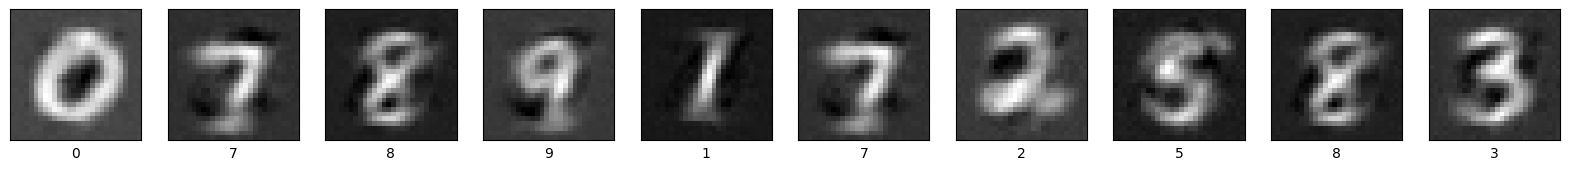

In [8]:
network = train(
    seed=SEED,
    layer_sizes=LAYER_SIZES,
    act_fn=ACT_FN,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    n_infer_iters=N_INFER_ITERS,
    test_every=TEST_EVERY,
    n_train_iters=N_TRAIN_ITERS
)